# APPLIANCE ENERGY USED PREDICTION

## Introduction

## Import Libraries

In [159]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, r2_score

## 1. Data Load and General Overview

In [2]:
# Load data
df = pd.read_csv(r'UCI-electricity/UCI_data.csv')

# General overview upon the df
print('\n____________ Dataset info ____________')
display(df.info())              
print('\n____________ Statistics of numeric features ____________')
display(df.describe()) 
print('\n____________ Some first data examples ____________')
df.head(5)


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9        

None


____________ Statistics of numeric features ____________


,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000



____________ Some first data examples ____________


,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [3]:
df['date'] = pd.to_datetime(df['date'])

## 2. Exploratory Data Analysis

In [5]:
eda_df = df.copy()

### Distribution of Features

#### Utilities

In [6]:
def plot_all_histograms_grid(df, font_scale=1.5, single_figsize=(5, 3), tick_label_size=10, color='c', n_cols=3):
    """
    Plot histograms for all numerical columns in a grid layout without hue.

    Parameters:
    - df: pandas df
    - font_scale: float, scale factor for font size
    - single_figsize: tuple, size of the each figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: histogram color
    - n_cols: int, number of columns in the grid
    
    """
    sns.set(font_scale=font_scale)
    numerical_columns = df.select_dtypes(include='number').columns
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
     # Adjust figsize based on number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(single_figsize[0] * n_cols, single_figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, column in enumerate(numerical_columns):
        sns.histplot(data=df, x=column, color=color, ax=axes[i], kde=True)
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(f'{column}')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='both', labelsize=tick_label_size)
        axes[i].axvline(df[column].mean(), color='r', linestyle='--', label='Mean', linewidth=2)
        axes[i].axvline(df[column].median(), color='g', linestyle='-', label='Median', linewidth=2)
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [7]:
def plot_all_boxplots_grid(df, font_scale=1, single_figsize=(3, 1.5), tick_label_size=10, color='c', n_cols=3):
    """
    Plot boxplots for all numerical columns in a grid layout.

    Parameters:
    - font_scale: float, scale factor for font size
    - single_figsize: tuple, size of the each figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: boxplot color
    - n_cols: int, number of columns in the grid
    
    """
    sns.set(font_scale=font_scale)
    numerical_columns = df.select_dtypes(include='number').columns
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    # Adjust figsize based on number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(single_figsize[0] * n_cols, single_figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, x=column, color=color, ax=axes[i])
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(f'{column}')
        axes[i].set_ylabel('Value')
        axes[i].tick_params(axis='both', labelsize=tick_label_size)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

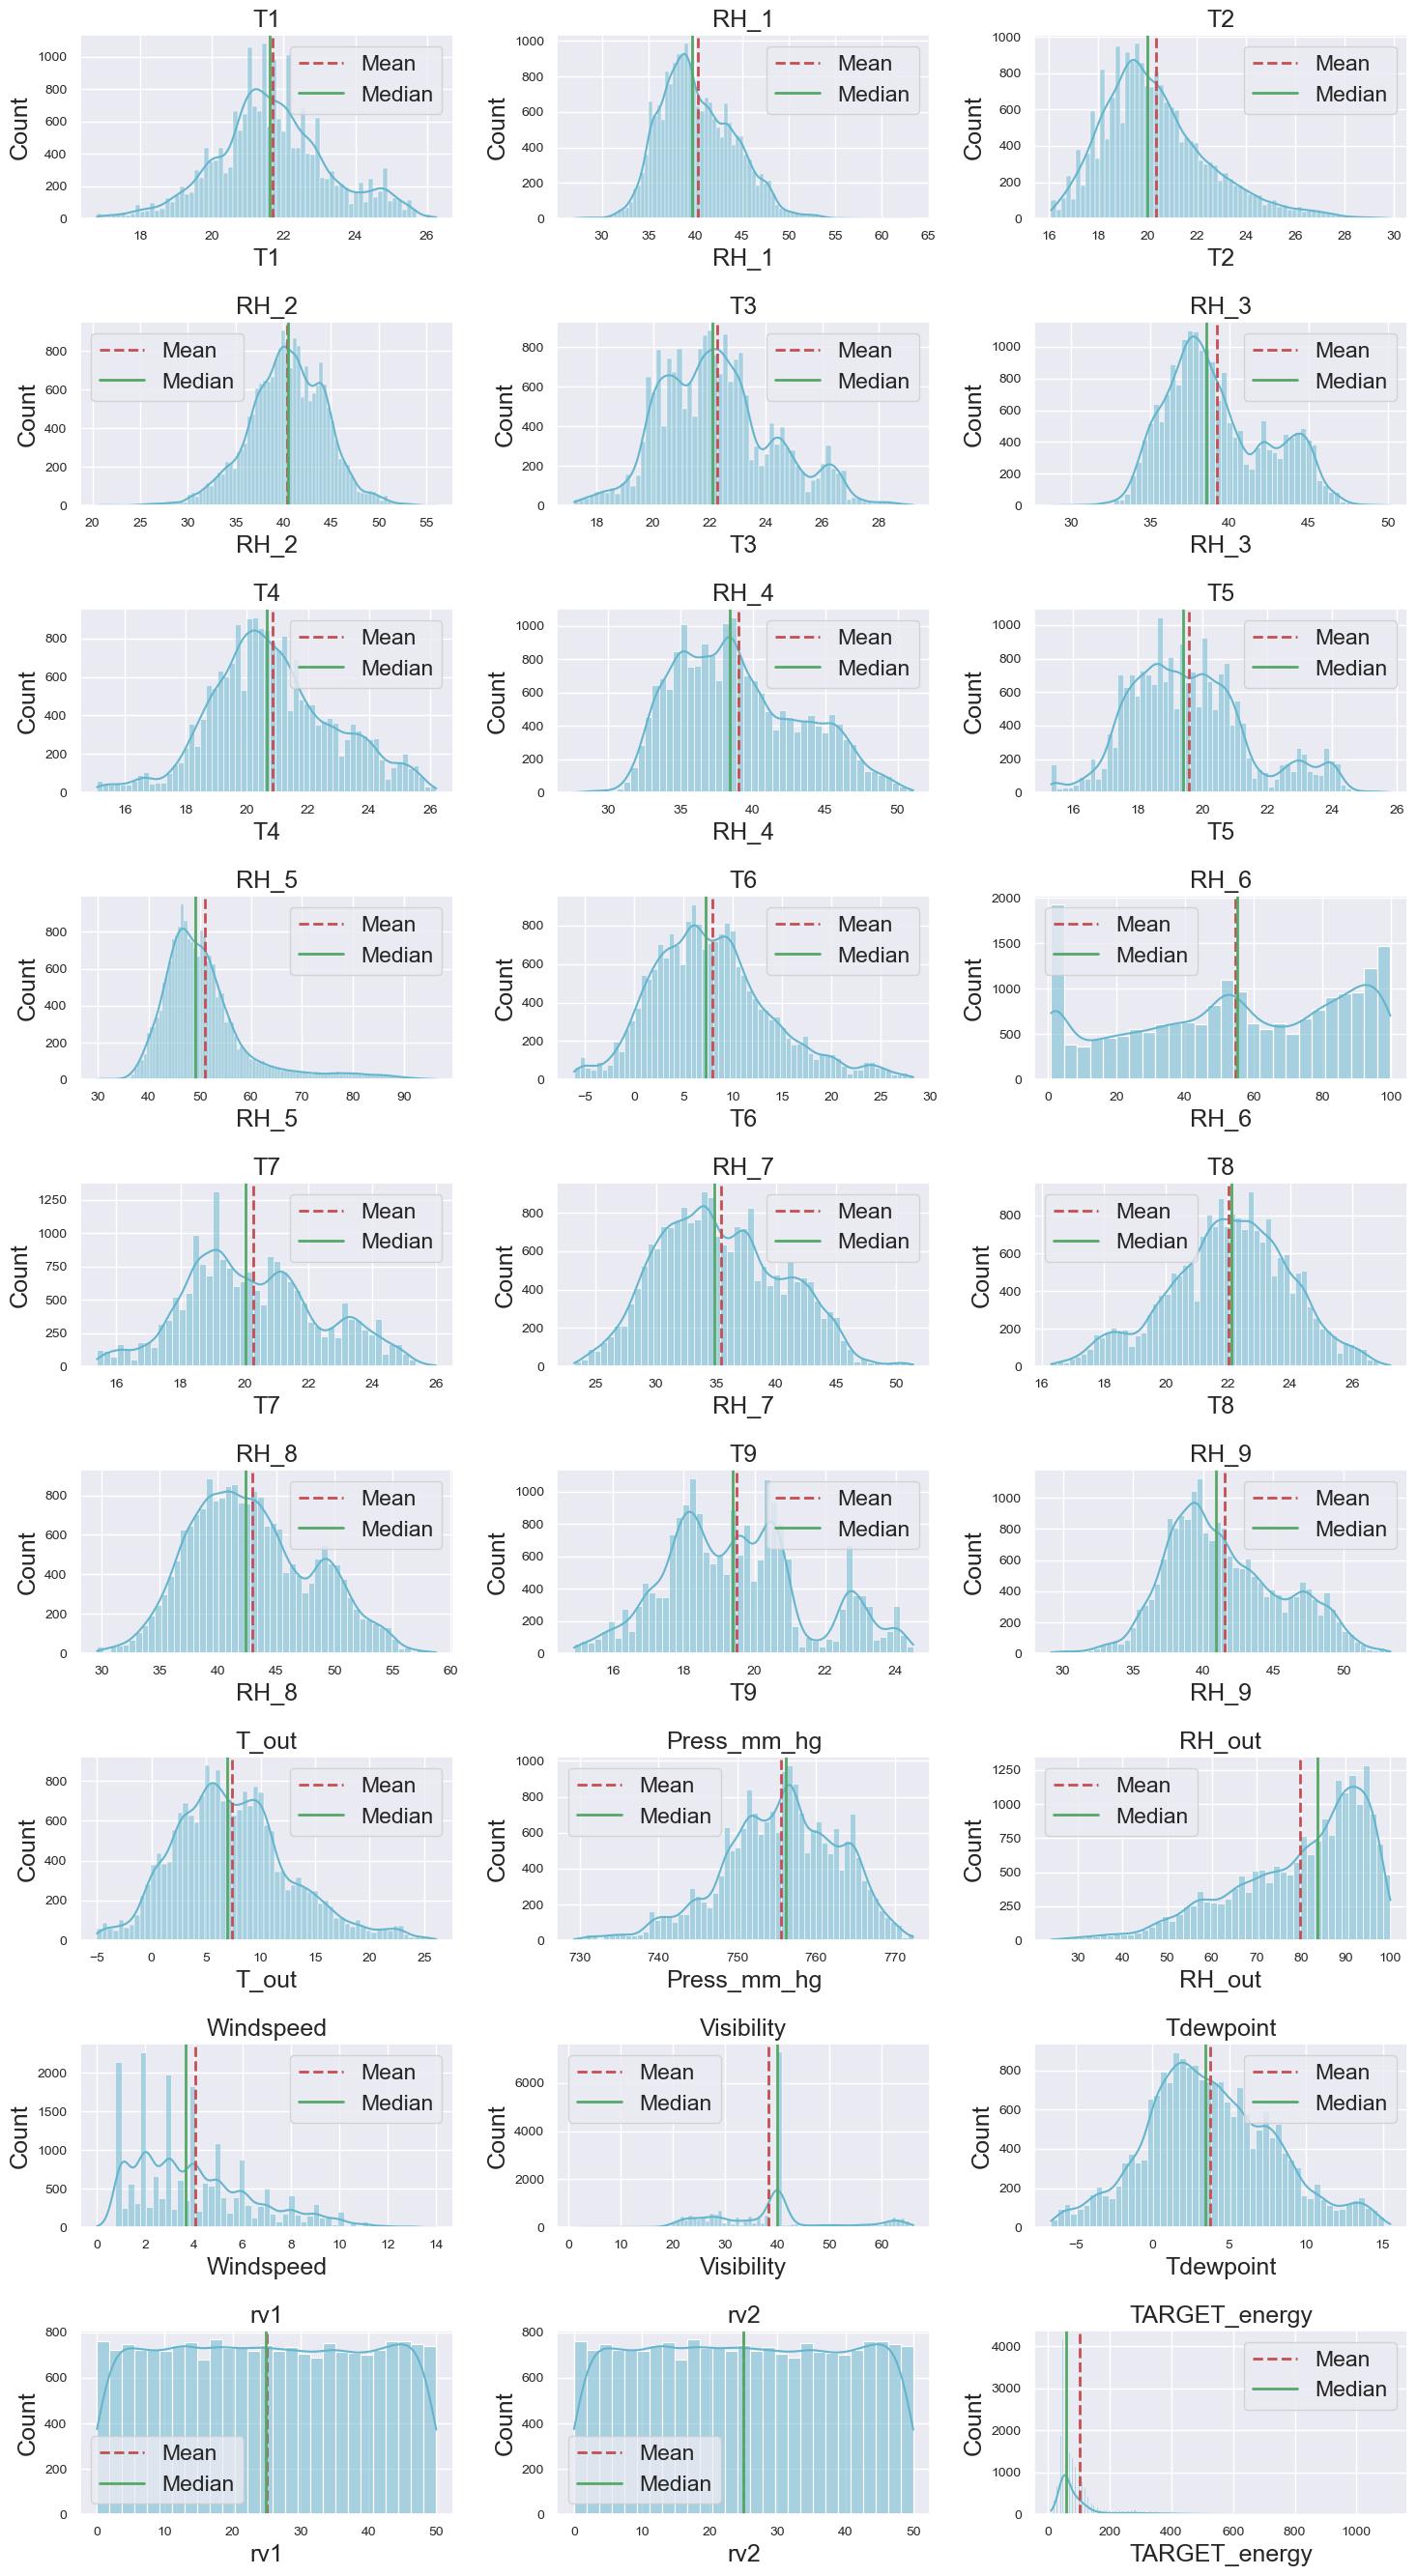

In [8]:
plot_all_histograms_grid(eda_df)

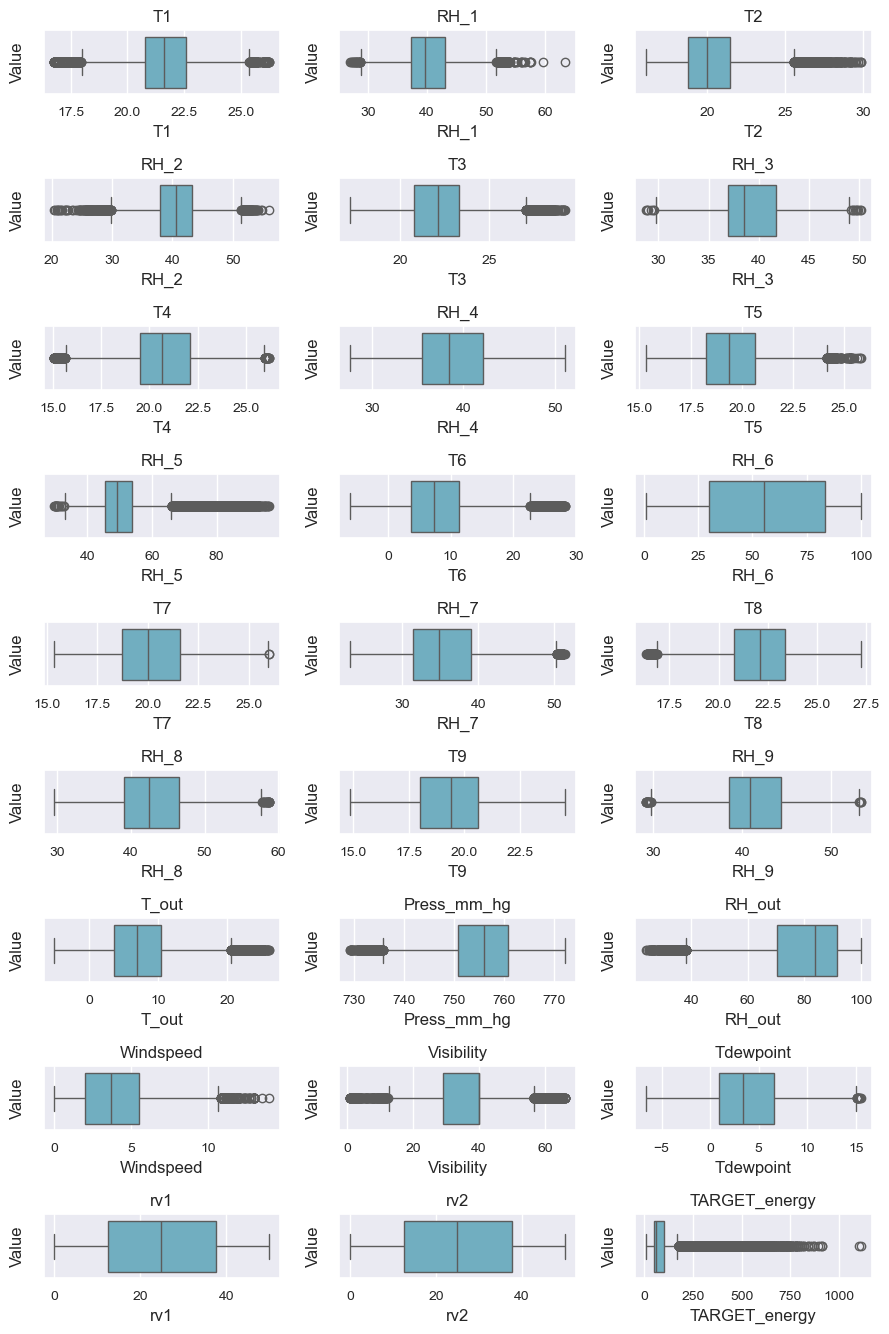

In [9]:
plot_all_boxplots_grid(eda_df)

### Features Correlation

Text(0.5, 1.0, 'Correlation Matrix of Data')

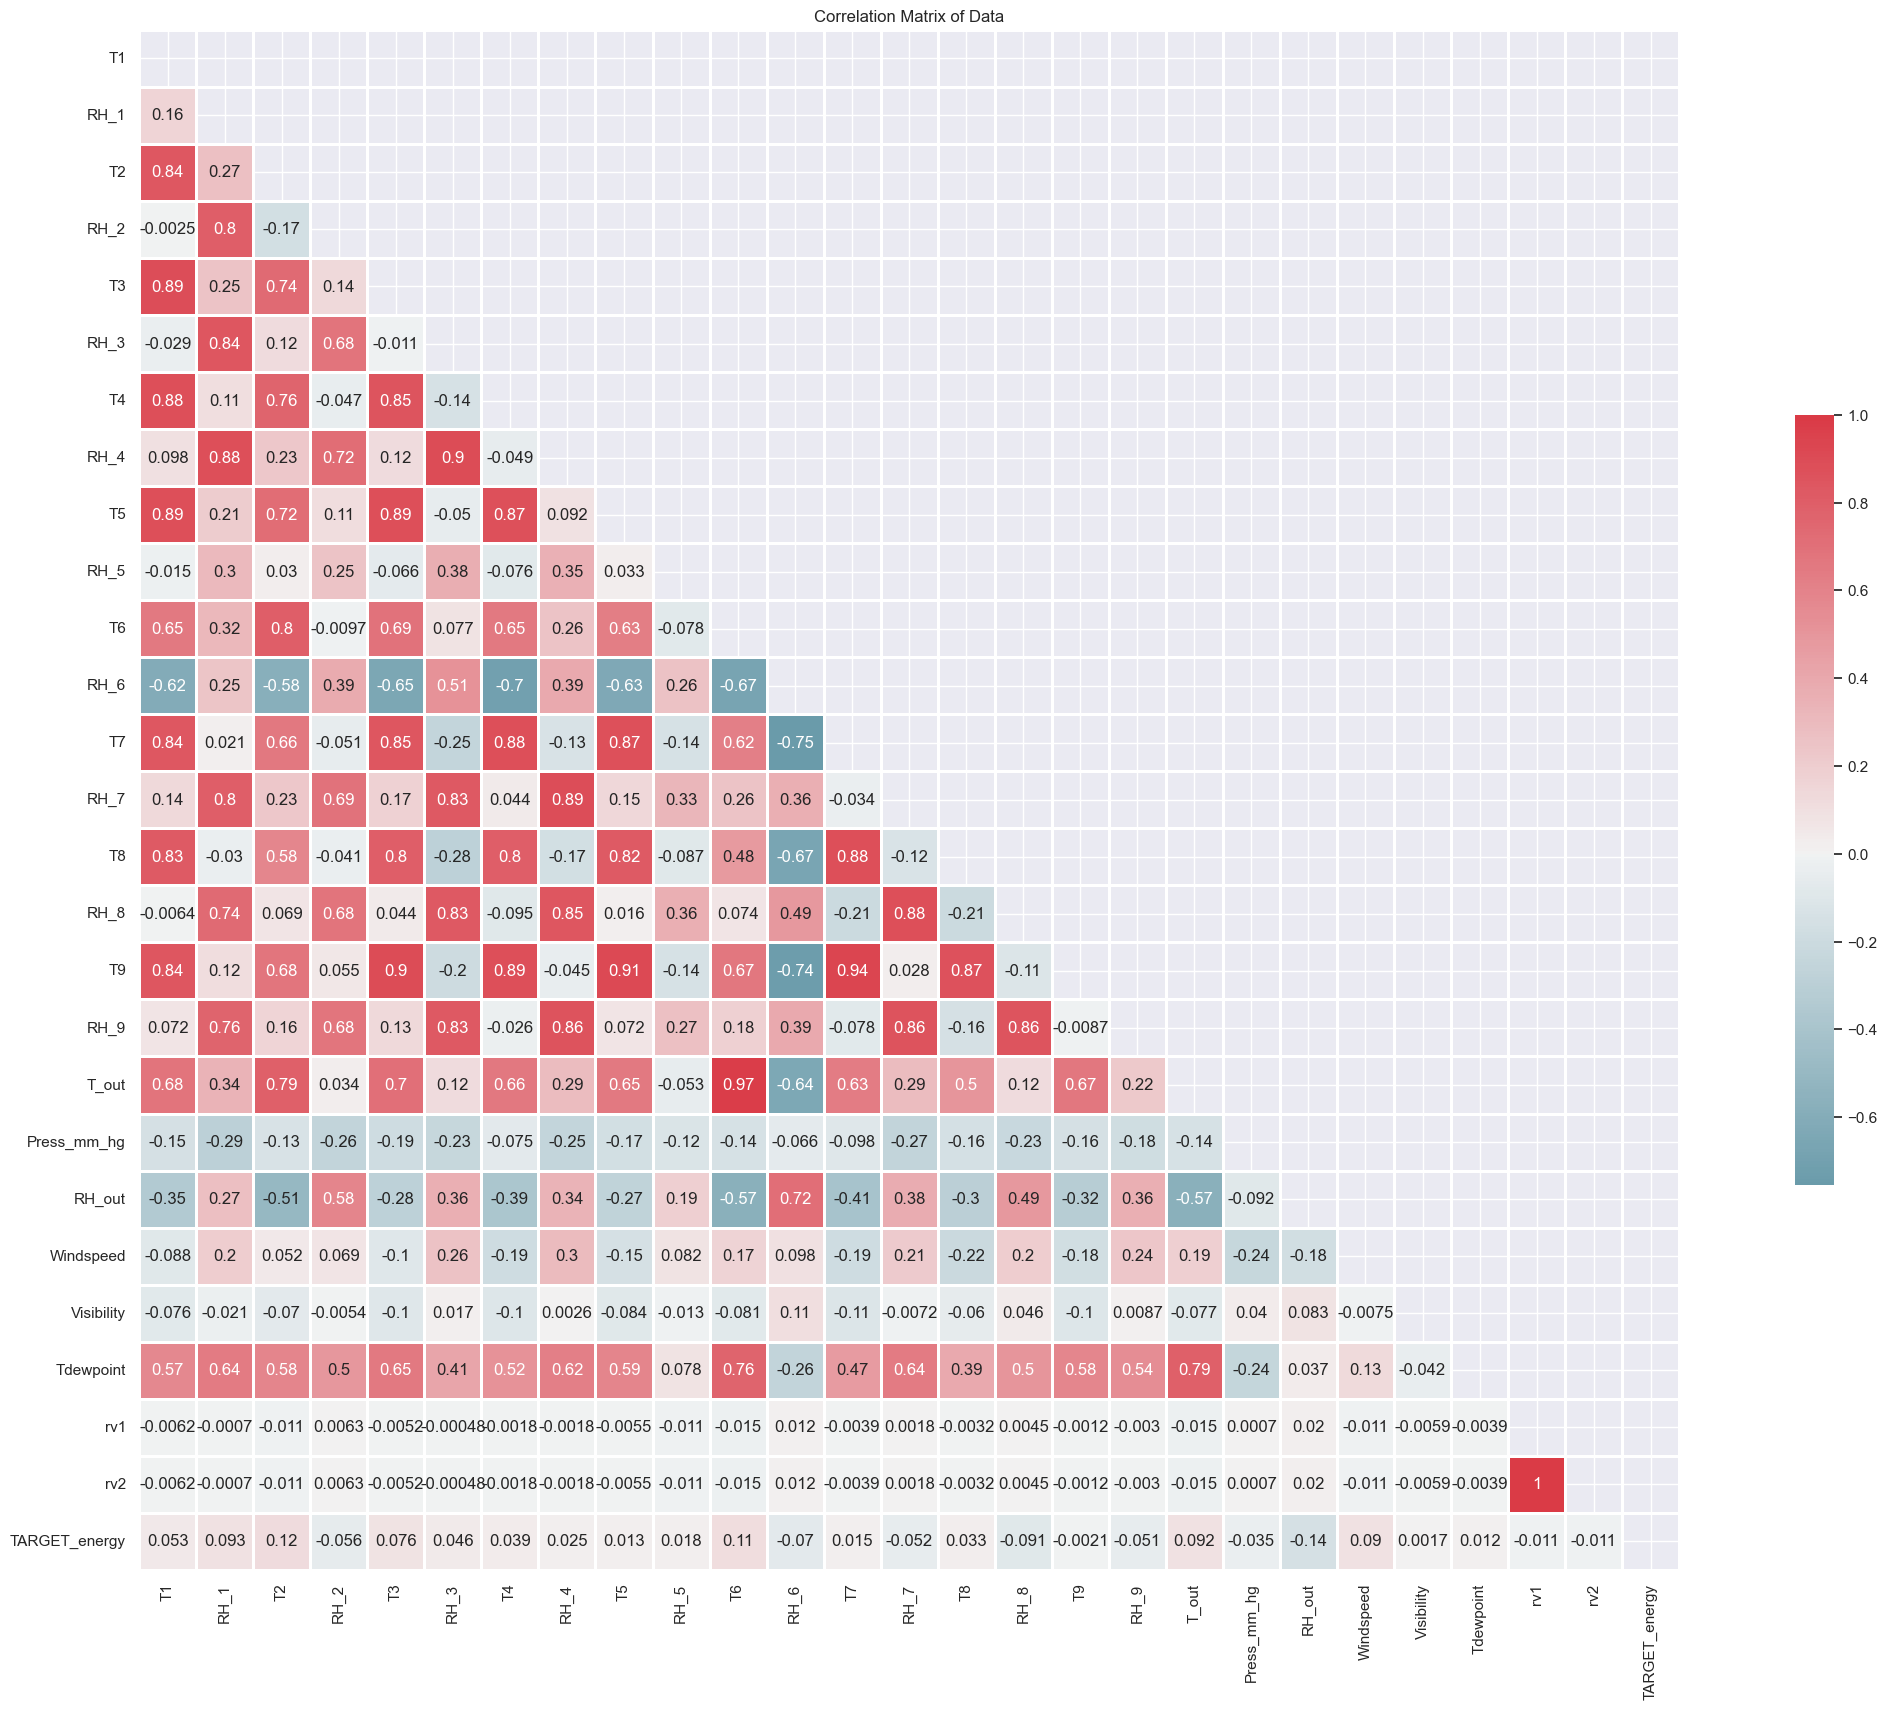

In [10]:
date_removed_df = df.drop(columns=['date'])

corr = date_removed_df.corr()

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (30, 20))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale=1)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = 1, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

### Analysis based on time features

#### Create time based features

In [16]:
# Convert 'date' to datetime
eda_df['date'] = pd.to_datetime(eda_df['date'])

In [17]:
eda_df['month'] = eda_df['date'].dt.month
eda_df['day_of_month'] = eda_df['date'].dt.day
eda_df['hour'] = eda_df['date'].dt.hour
eda_df['minute'] = eda_df['date'].dt.minute
eda_df['day_of_year'] = eda_df['date'].dt.day_of_year

# drop date
# eda_df = eda_df.drop(columns=['date'], axis=1)

In [18]:
weeknums = [[0,1,2,3,4], [5,6]]

# is_weekday with weekday=1 and weekend=0
eda_df['is_weekday'] = [1 if i.dayofweek in weeknums[0] else 0 for i in eda_df['date']]

In [19]:
eda_df['is_daytime'] = [1 if i.hour < 24 and i.hour > 6 else 0 for i in eda_df['date']] # 1 if daytime, 0 if nighttime

In [20]:
# The day of the week with Monday=0 to Sunday=6.
eda_df['weekday'] = [i.dayofweek for i in eda_df['date']]

#### Hourly Energy Consumption

##### General

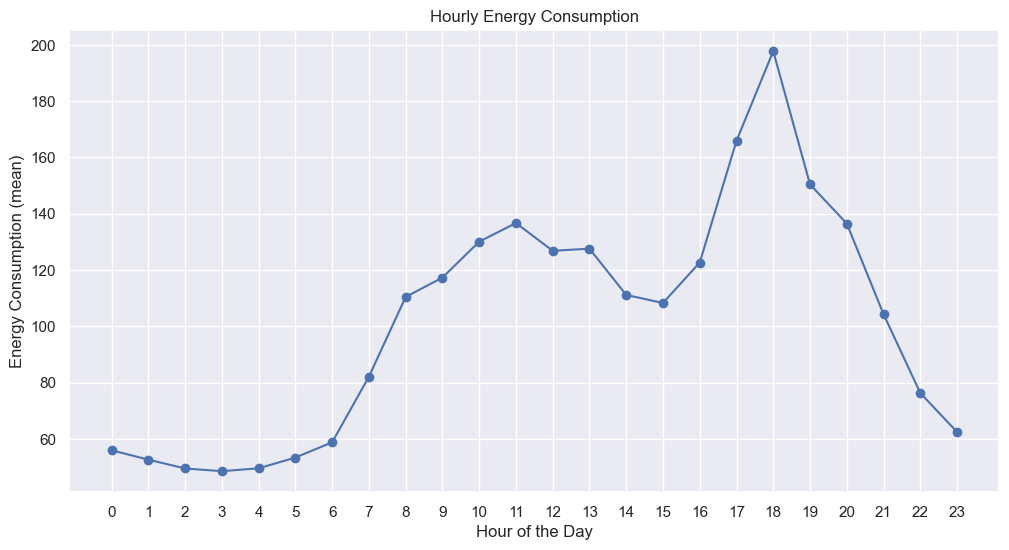

In [21]:
hourly_avg_energy = eda_df.groupby('hour')['TARGET_energy'].mean()


plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_energy.index, hourly_avg_energy.values, marker='o', linestyle='-')
plt.title('Hourly Energy Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (mean)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

##### Weekdays and weekends

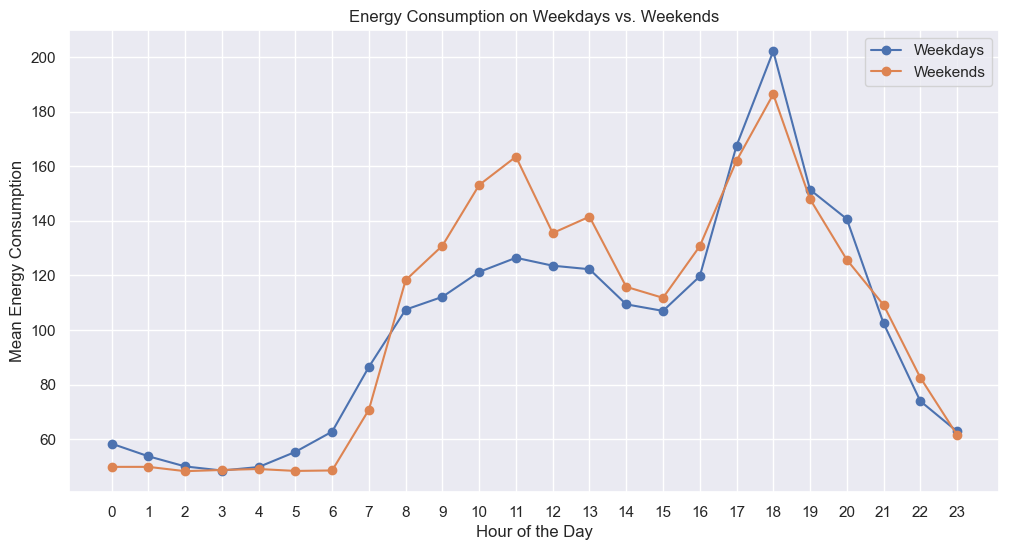

In [22]:
plt.figure(figsize=(12, 6))

# Group the data by 'weekday' and calculate the mean energy consumption for weekdays and weekends
hourly_weekday_energy = eda_df[eda_df['weekday'] < 5].groupby('hour')['TARGET_energy'].mean()
hourly_weekend_energy = eda_df[eda_df['weekday'] >= 5].groupby('hour')['TARGET_energy'].mean()

# Plot energy consumption for weekdays and weekends
plt.plot(hourly_weekday_energy.index, hourly_weekday_energy.values, label='Weekdays', marker='o')
plt.plot(hourly_weekend_energy.index, hourly_weekend_energy.values, label='Weekends', marker='o')

plt.title('Energy Consumption on Weekdays vs. Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Energy Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend()

plt.show()

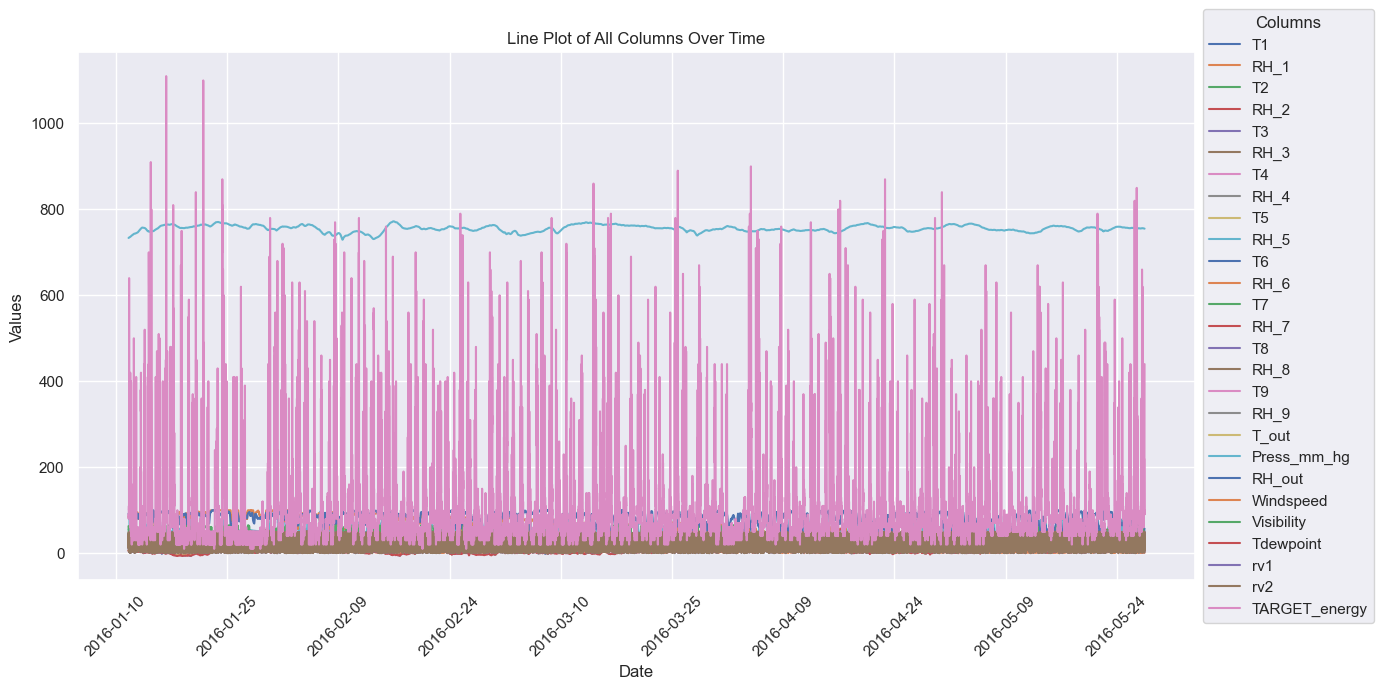

In [24]:
# Set the figure size
plt.figure(figsize=(14, 7))

# Plot all columns against 'date'
for column in df.columns:
    if column != 'date':  # Skip the 'date' column itself
        sns.lineplot(data=df, x='date', y=column, label=column)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Columns')

plt.xticks(rotation=45)  # Rotate dates for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))  # Show more date labels

plt.title('Line Plot of All Columns Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.tight_layout() 
plt.show()


In [32]:
df_small = df[0:1733].copy()

#### TARGET_energy analysis

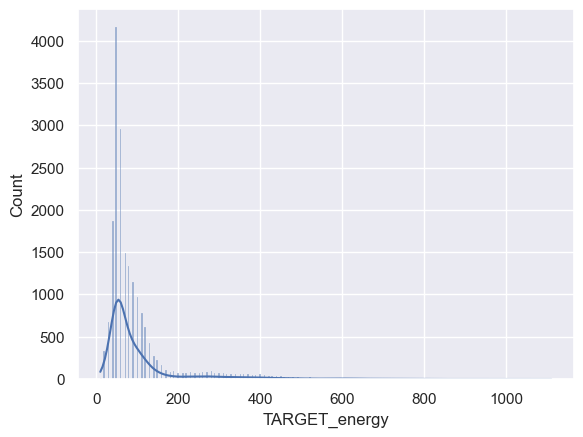

In [26]:
sns.histplot(df['TARGET_energy'], kde=True)
plt.show()

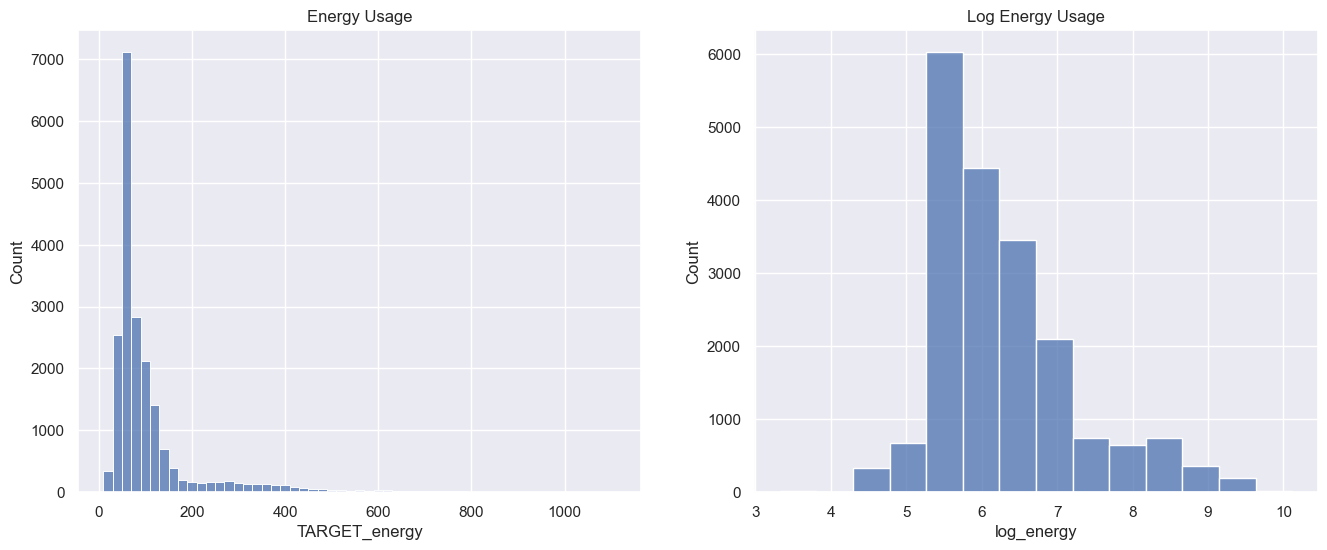

In [37]:
# log2 is chosen as the value range is small
# the minimum value is not 0 so choosing the function in the log operator as x is fine

eda_df['log_energy'] = eda_df['TARGET_energy'].apply(lambda x: np.log2(x))

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.histplot(x='TARGET_energy', data=eda_df, binwidth=20, ax=ax[0])
sns.histplot(x='log_energy', data=eda_df, binwidth=0.5, ax=ax[1])

ax[0].set_title('Energy Usage')
ax[1].set_title('Log Energy Usage')

plt.show()

## 3. Data Preprocessing

### Remove Missing Values

In [110]:
class RemoveMissingValues(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        return self


    def transform(self, X, y = None):
        '''
        Replaces the outliers with the bounds of respective column
        Parameters: 
            X : Dataframe you want to replace outliers.
        Returns :  A Dataframe with removed outliers.
        '''
        return X.dropna()

### Outliers 

In [39]:
outliers_eda_df = df.copy()

In [41]:
def detect_outliers_iqr(df):
    # Calculate the first quartile (Q1) and third quartile (Q3) for each column
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR) for each column
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outliers for each column
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Check for outliers in each column and count the number of outliers
    outliers_count = (df < lower_bound) | (df > upper_bound)
    num_outliers = outliers_count.sum()

    return num_outliers

In [43]:
outliers_per_column = detect_outliers_iqr(outliers_eda_df)
print("Number of outliers per column:")
print(outliers_per_column.sort_values(ascending = False))

Number of outliers per column:
Visibility       2522
TARGET_energy    2210
RH_5             1330
T2                546
T6                515
T1                515
T_out             436
RH_out            239
RH_2              235
Press_mm_hg       219
T3                217
Windspeed         214
T4                186
T5                179
RH_1              146
T8                 71
RH_7               42
RH_9               21
RH_8               17
RH_3               15
Tdewpoint          10
T7                  2
T9                  0
RH_6                0
RH_4                0
rv1                 0
rv2                 0
date                0
dtype: int64


In [48]:
columns = list(outliers_eda_df.columns)

In [50]:
for col in columns:
  q_25= np.percentile(df[col], 25)
  q_75 = np.percentile(df[col], 75)
  iqr = q_75 - q_25
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  lower = q_25 - cut_off
  upper = q_75 + cut_off
  # identify outliers
  outliers = [x for x in df[col] if x < lower or x > upper]
  #removing outliers
  if len(outliers)!=0:

    def bin(row):
      if row[col]> upper:
        return upper
      if row[col] < lower:
        return lower
      else:
        return row[col]

    outliers_eda_df[col] =  df.apply (lambda row: bin(row), axis=1)

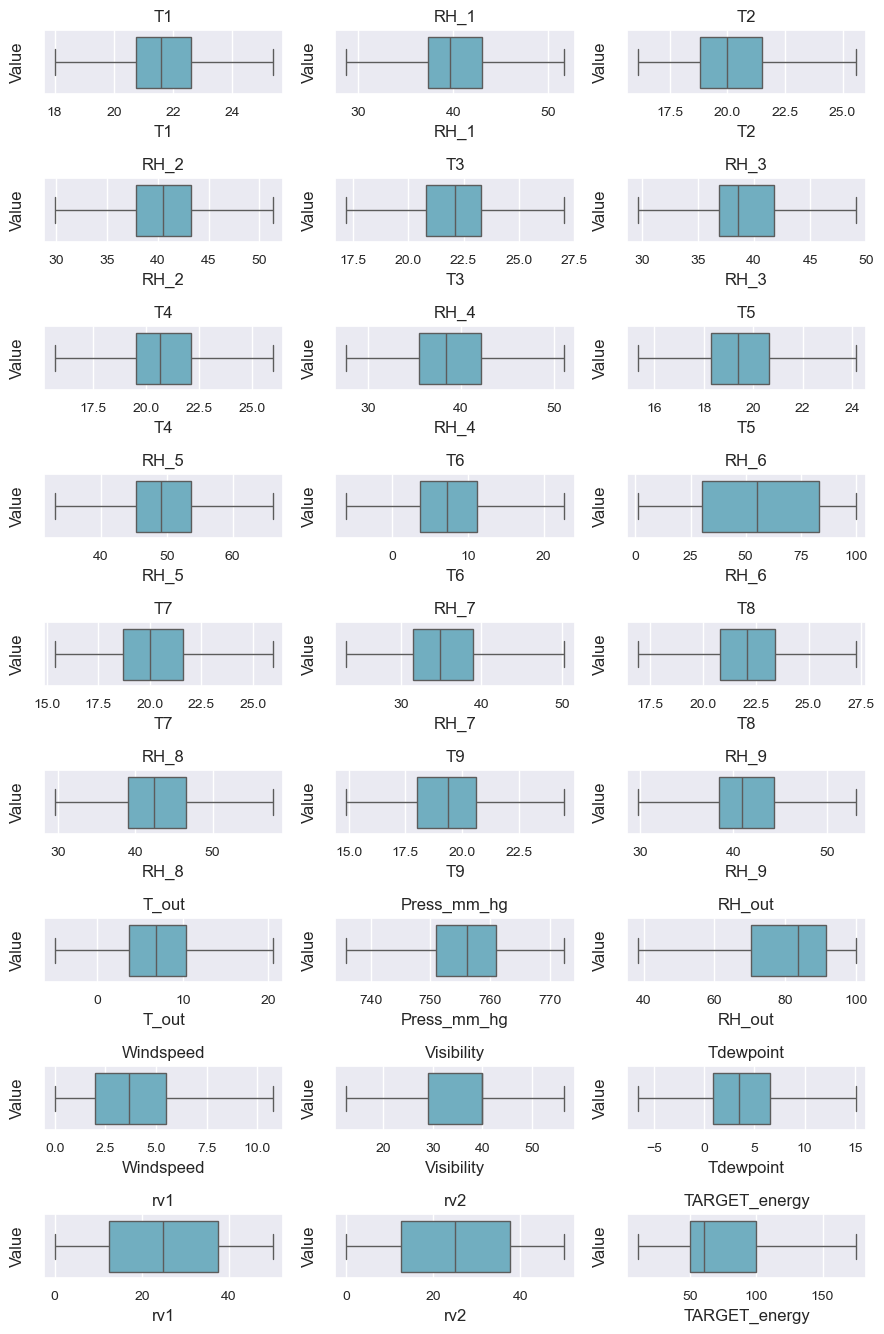

In [51]:
plot_all_boxplots_grid(outliers_eda_df)

In [52]:
#creating custom Transformer for handling ouliers
class HandleOutliers(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        '''
        Get the IQR upper and lower bounds of each features
        Parameters:
            X : Dataframe which you want to note percentile.
        '''
        outlier_estimator_dict = {}

        for col in X.columns:
            q_25= np.percentile(df[col], 25)
            q_75 = np.percentile(df[col], 75)
            iqr = q_75 - q_25
            cut_off = iqr * 1.5

            upper_bound = q_25 - cut_off
            lower_bound = q_75 + cut_off
            outlier_estimator_dict[col] = {
                "upper_bound": upper_bound,
                "lower_bound": lower_bound}
        self.outlier_estimator_dict = outlier_estimator_dict
        return self


    def transform(self, X, y = None):
        '''
        Replaces the outliers with the bounds of respective column
        Parameters: 
            X : Dataframe you want to replace outliers.
        Returns :  A Dataframe with removed outliers.
        '''
        for col in X.columns:
            col_dict = self.outlier_estimator_dict[col]
            X[col] = np.where(X[col]>col_dict['upper_bound'], col_dict['upper_bound'],X[col])
            X[col] = np.where(X[col]<col_dict['lower_bound'], col_dict['lower_bound'],X[col])
        
        self.final_column_names = X.columns
        return X

### Transformation

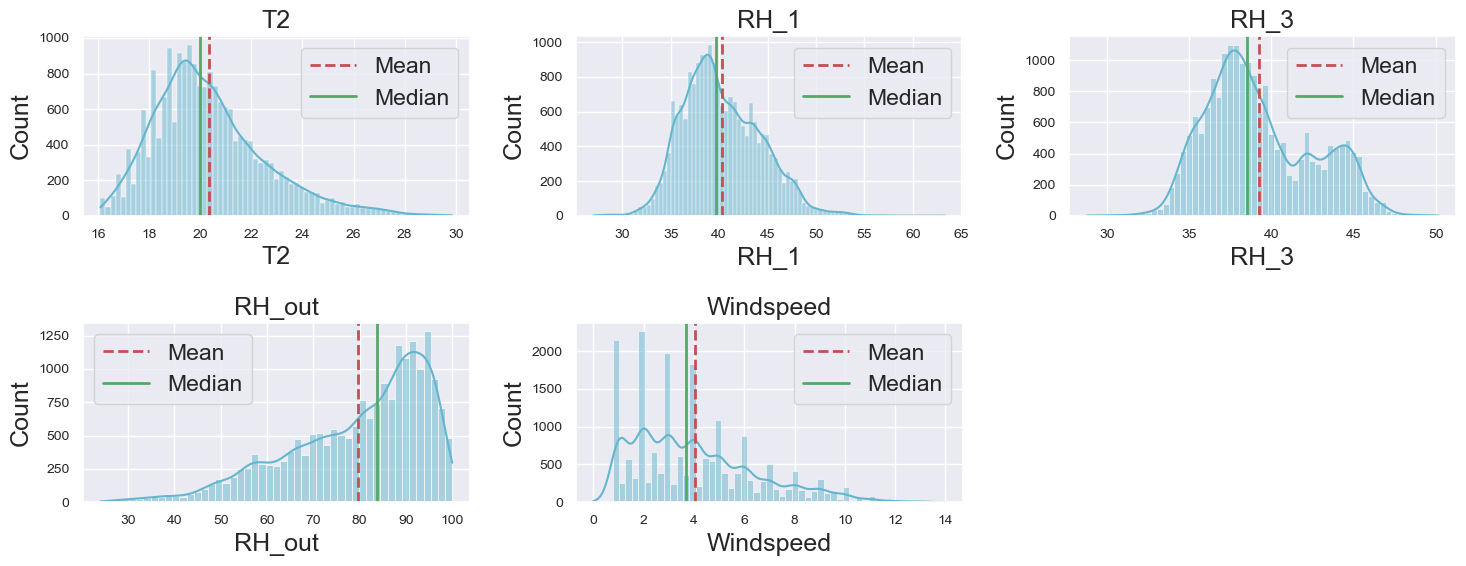

In [53]:
plot_all_histograms_grid(eda_df[['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed']])

In [55]:
skewness_transformer = ColumnTransformer(transformers=[
        ("skewness_transformer", PowerTransformer(copy=True), ['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed'])
], remainder='passthrough')

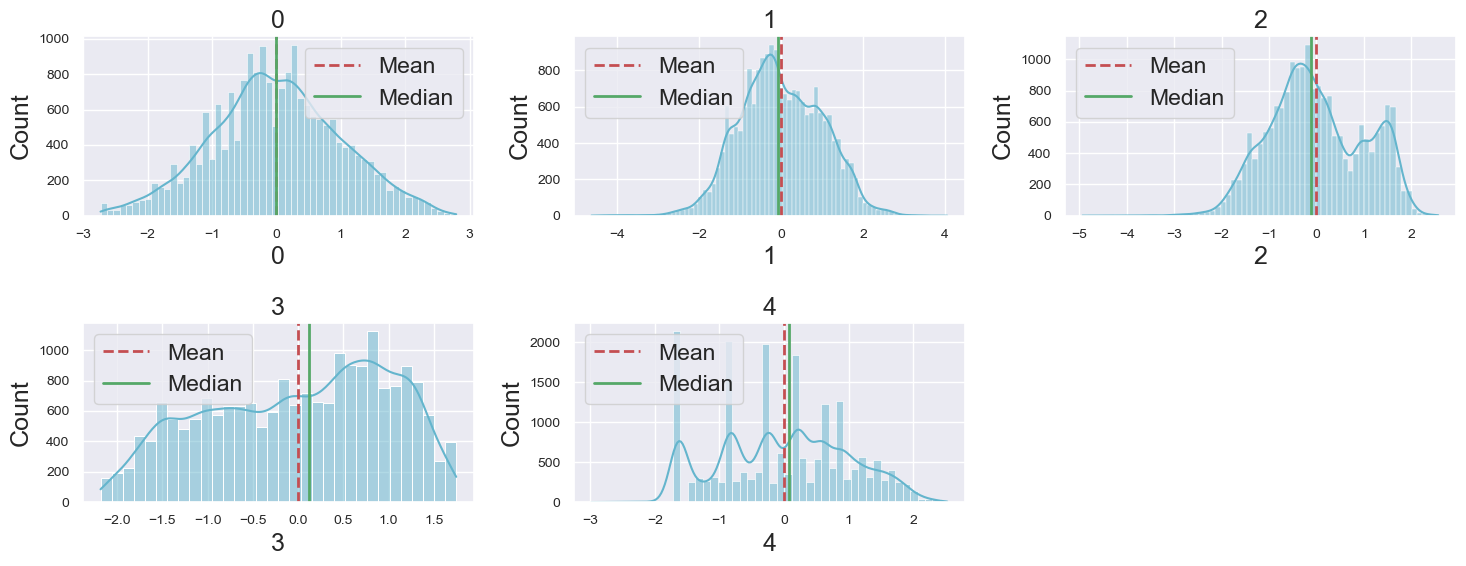

In [56]:
# Fit and transform the data using the PowerTransformer
power_transformed = pd.DataFrame(skewness_transformer.fit_transform(eda_df[['T2', 'RH_1', 'RH_3', 'RH_out' ,'Windspeed']]))

plot_all_histograms_grid(power_transformed)

### Feature Engineering

In [57]:
df['log_energy'] = df['TARGET_energy'].apply(lambda x: np.log2(x))

#### Lag Features

In [60]:
lags = [1,3,6,18,144]
for lag in lags:
    eda_df['log_energy_lag'+str(lag)] = eda_df['log_energy'].shift(lag).astype(np.float16)

In [61]:
eda_df.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,day_of_year,is_weekday,is_daytime,weekday,log_energy,log_energy_lag1,log_energy_lag3,log_energy_lag6,log_energy_lag18,log_energy_lag144
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,110,1,1,1,5.906891,NaN,NaN,NaN,NaN,NaN
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,65,0,0,5,5.643856,5.906250,NaN,NaN,NaN,NaN
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,74,1,1,0,6.321928,5.644531,NaN,NaN,NaN,NaN
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,22,1,1,4,5.321928,6.320312,5.906250,NaN,NaN,NaN
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,41,1,0,2,5.906891,5.320312,5.644531,NaN,NaN,NaN


In [84]:
eda_df = eda_df.dropna()

#### Time Based Features

In [68]:
class AddTimeBasedFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X, y = None):
        return self


    def transform(self,X,y=None):
        X['month'] = X.date.dt.month
        X['day_of_month'] = X.date.dt.day
        X['hour'] = X.date.dt.hour
        X['minute'] = X.date.dt.minute
        X['day_of_year'] = X.date.dt.day_of_year
        X['day_of_week'] = [i.dayofweek for i in X.date]
        X['is_weekday'] = [1 if i.dayofweek in weeknums[0] else 0 for i in X.date]
        X['is_daytime'] = [1 if i.hour < 24 and i.hour > 6 else 0 for i in X.date]
        
        return X.drop('date',axis = 1)

#### Average Features

In [70]:
eda_df['T_avg'] = eda_df[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']].mean(axis =1)

In [72]:
eda_df['RH_avg'] = eda_df[['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']].mean(axis =1)

In [112]:
class AddAverageFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self,X, y = None):
        return self

    def transform(self,X, y = None):
        '''
        Adds average features of the appliances measurements
        Parameter : dataframe 
        Returns : dataframe with the average features.
        '''
        X['T_avg'] = X[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']].mean(axis =1)
        X['RH_avg'] = X[['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']].mean(axis =1)
        
        return X

### Feature Selection

#### Remove Random Features

In [100]:
class RemoveRandomFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
          return self
         
    def transform(self, X,y = None):
         '''
         Remove random features
         Returns : Dataframe by removing the random features.
         '''
         return X.drop(columns['rv1', 'rv2'],axis=1)


#### PCA

In [78]:
print('Number of current features: ', len(list(eda_df.columns)))

Number of current features:  44


Text(0, 0.5, 'cumulative explained variance')

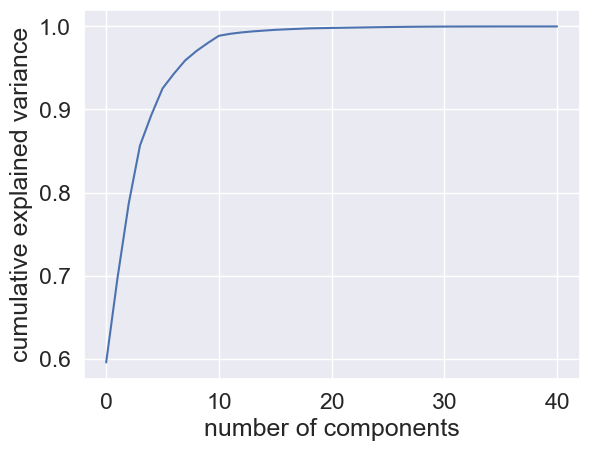

In [90]:
X_PCA = eda_df.drop(columns=['TARGET_energy', 'date', 'log_energy'])

pca = PCA().fit(X_PCA)


# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [92]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1

In [94]:
print("Number of components to keep:", n_components)

Number of components to keep: 8


In [96]:
pca_transformer = PCA(n_components=8)

### Data Scaling

In [120]:
standard_scaler = StandardScaler()

### Preprocessing Pipeline

In [122]:
preprocessor_steps = [             
    ('remove_outliers',HandleOutliers()),
    ('remove_misssing_values', RemoveMissingValues()),
    ('transformation', skewness_transformer),
    ('add_average_features',AddAverageFeatures()),
    ('add_timebased_features',AddTimeBasedFeatures()),
    ('remove_random_features', RemoveRandomFeatures()),
    ('scaler',standard_scaler)
]

In [128]:
preprocessing_pipeline = Pipeline(preprocessor_steps)

In [135]:
preprocessing_pipeline_PCA = Pipeline(preprocessor_steps + [('pca', pca_transformer)])

## 4. Modelling

In [76]:
eda_df.columns

Index(['date', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
       'rv2', 'TARGET_energy', 'month', 'day_of_month', 'hour', 'minute',
       'day_of_year', 'is_weekday', 'is_daytime', 'weekday', 'log_energy',
       'log_energy_lag1', 'log_energy_lag3', 'log_energy_lag6',
       'log_energy_lag18', 'log_energy_lag144', 'T_avg', 'RH_avg'],
      dtype='object')

### Split Data

- Ensure Temporal Integrity: Always ensure that training data precedes validation/test data.
- Avoid Data Leakage: Ensure that no information from the future (test/validation set) is used in training.
- Scaling and Normalization: If you scale or normalize data, do it based on the training set and apply the same transformation to the test set to avoid look-ahead bias.

In [141]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

In [143]:
train_set.shape

(16446, 29)

In [145]:
test_set.shape

(3289, 29)

##### Without lag features

In [147]:
lagcolumns = ['log_energy_1', 'log_energy_3',
              'log_energy_6', 'log_energy_18', 
              'log_energy_36', 'log_energy_44']

train_set_nolag = train_set.copy().drop(columns=lagcolumns, axis=1)
test_set_nolag = test_set.copy().drop(columns=lagcolumns, axis=1)

KeyError: "['log_energy_1', 'log_energy_3', 'log_energy_6', 'log_energy_18', 'log_energy_36', 'log_energy_44'] not found in axis"

##### With lag features

In [ ]:
train_set_lag = train_set.copy()
test_set_lag = test_set.copy()

##### PCA

In [150]:
train_set_pca = train_set.copy()
test_set_pca = test_set.copy()

### Utilities

In [ ]:
def train_and_report(model, X_train, y_train, X_test, y_test, model_name="", grid=False):
    # train the model
    model.fit(X_train, y_train)

    
    # evaluate model with cross validation
    cv_mse_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

    # calculate the mean metrics from cross validation
    train_mse = cv_mse_scores.mean()
    train_re = cv_r2_scores.mean()
    
    # predict on test set
    y_pred = model.predict(X_test)

    # score on test set
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    # plot the result and prediction
    result_pred_df = pd.DataFrame()
    result_pred_df['actual'] = y_test
    result_pred_df['prediction'] = y_pred

    result_pred_df.plot()

### Linear Regression

### LightGBM

### Random Forest